We'll start by loading the necessary libraries and the dataset from Huggingface.

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Download the Huggingface Emoji dataset
from datasets import load_dataset
dataset = load_dataset('valhalla/emoji-dataset')


We'll filter by "hair" as the theme for our emojis, just for fun. This way we can classify emojis by gender later on. 

In [3]:

def filter_images(dataset, theme):
    filtered_images = []
    for i, text in enumerate(dataset['train']['text']):
        if theme in text:
            filtered_images.append(dataset['train']['image'][i])
    return filtered_images


# Filter the images based on the theme
theme = 'hair'
filtered_images = filter_images(dataset, theme)

# Display the length of the filtered images
print(f"Number of images with the theme '{theme}': {len(filtered_images)}")

# Display the length of the original dataset
print(f"Number of images in the original dataset: {len(dataset['train']['image'])}")


Number of images with the theme 'hair': 61
Number of images in the original dataset: 2749


We'll create a train/validation/test split with a 60-20-20 divide. 

In [4]:
train_images, val_images = train_test_split(filtered_images, test_size=0.4, random_state=42) # 60% for training, 40% for validation and testing
val_images, test_images = train_test_split(val_images, test_size=0.5, random_state=42) # 20% for validation, 20% for testing

# Display the number of images in each set
print(f"Number of training images: {len(train_images)}")
print(f"Number of validation images: {len(val_images)}")
print(f"Number of test images: {len(test_images)}")

Number of training images: 36
Number of validation images: 12
Number of test images: 13


We'll resize images to be 64x64 resolution. 

In [5]:
def resize_images(images, size):
    resized_images = []
    for image in images:
        img = image.resize(size)
        resized_images.append(img)
    return resized_images

# Resize the images
size = (64, 64)
train_images = resize_images(train_images, size)
val_images = resize_images(val_images, size)
test_images = resize_images(test_images, size)

Since our subset of the dataset is small, we'll expand to be closer to 600-200-200. 

In [6]:
train_images = train_images * (600 // len(train_images))
val_images = val_images * (200 // len(val_images))
test_images = test_images * (200 // len(test_images))


In [7]:
# Display the length of train_images, val_images, and test_images
print(f"Number of training images: {len(train_images)}")
print(f"Number of validation images: {len(val_images)}")
print(f"Number of test images: {len(test_images)}")


Number of training images: 576
Number of validation images: 192
Number of test images: 195


Now, we'll create an EmojiDataset class that will allow for transformations/data augmentation.

In [8]:
class EmojiDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image
    

We'll randomly apply horizontal flips and a 30 degree rotation to each dataset for augmentation. 

In [9]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor()
])

# Create the training, validation, and test datasets
train_dataset = EmojiDataset(train_images, transform=transform)
val_dataset = EmojiDataset(val_images, transform=transforms.ToTensor())
test_dataset = EmojiDataset(test_images, transform=transforms.ToTensor())


In [10]:
# Create the training, validation, and test dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Now we can start cooking with our Autoencoder. We'll take in our image and produce an output image of the same dimensions.

In [48]:
import torch.nn.functional as F

class DenseConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DenseConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels + out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels + 2*out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels + 3*out_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x1 = F.leaky_relu(self.conv1(x), inplace=True)
        x2 = F.leaky_relu(self.conv2(torch.cat([x, x1], 1)), inplace=True)
        x3 = F.leaky_relu(self.conv3(torch.cat([x, x1, x2], 1)), inplace=True)
        x4 = F.leaky_relu(self.conv4(torch.cat([x, x1, x2, x3], 1)), inplace=True)
        return x4


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder =  nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),   # b, 16, 32, 32
            nn.LeakyReLU(True),
            DenseConvBlock(32, 64),  # b, 32, 32, 32
            nn.MaxPool2d(2, stride=2),  # b, 32, 16, 16
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # b, 64, 32, 32
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # b, 3, 64, 64
            nn.Tanh()
        )

    def forward(self, x):
        # Encoding
        x = self.encoder(x)
        if self.training:
            noise = torch.randn_like(x)
            x = x + 0.05*noise
        # Decoding
        x = self.decoder(x)
        return x
    
    

MPS is available


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1/100 | Training loss: 4.4437
Epoch 1/100 | Validation loss: 2.1909


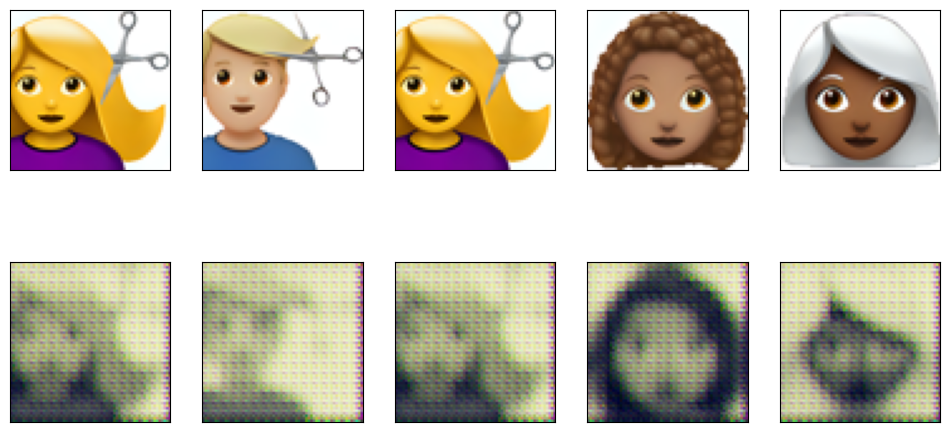

Epoch 2/100 | Training loss: 1.5865
Epoch 2/100 | Validation loss: 1.1654
Epoch 3/100 | Training loss: 1.0062
Epoch 3/100 | Validation loss: 0.7085
Epoch 4/100 | Training loss: 0.7545
Epoch 4/100 | Validation loss: 0.5387
Epoch 5/100 | Training loss: 0.6291
Epoch 5/100 | Validation loss: 0.4466
Epoch 6/100 | Training loss: 0.5439
Epoch 6/100 | Validation loss: 0.3938
Epoch 7/100 | Training loss: 0.5036
Epoch 7/100 | Validation loss: 0.3421
Epoch 8/100 | Training loss: 0.4505
Epoch 8/100 | Validation loss: 0.3099
Epoch 9/100 | Training loss: 0.4119
Epoch 9/100 | Validation loss: 0.2790
Epoch 10/100 | Training loss: 0.3848
Epoch 10/100 | Validation loss: 0.2624
Epoch 11/100 | Training loss: 0.3658
Epoch 11/100 | Validation loss: 0.2501
Epoch 12/100 | Training loss: 0.3429
Epoch 12/100 | Validation loss: 0.2192
Epoch 13/100 | Training loss: 0.3275
Epoch 13/100 | Validation loss: 0.2089
Epoch 14/100 | Training loss: 0.3111
Epoch 14/100 | Validation loss: 0.1975
Epoch 15/100 | Training loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 20/100 | Training loss: 0.2501
Epoch 20/100 | Validation loss: 0.1633


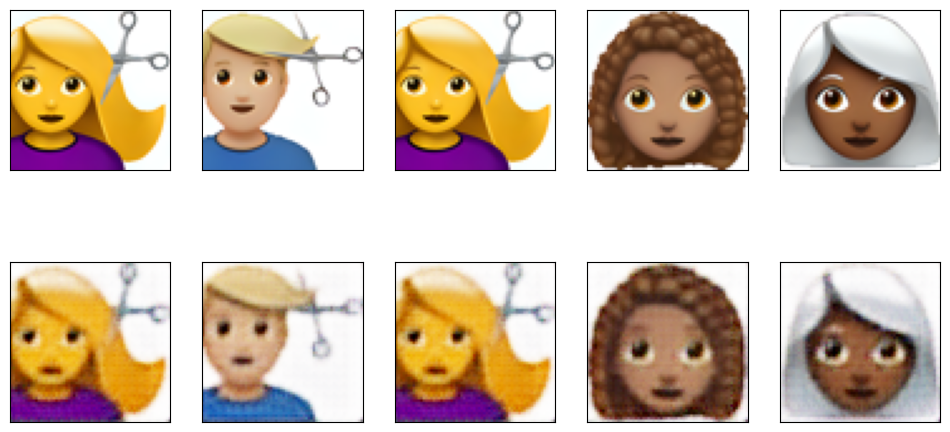

Epoch 21/100 | Training loss: 0.2460
Epoch 21/100 | Validation loss: 0.1531
Epoch 22/100 | Training loss: 0.2365
Epoch 22/100 | Validation loss: 0.1476
Epoch 23/100 | Training loss: 0.2315
Epoch 23/100 | Validation loss: 0.1449
Epoch 24/100 | Training loss: 0.2278
Epoch 24/100 | Validation loss: 0.1428
Epoch 25/100 | Training loss: 0.2225
Epoch 25/100 | Validation loss: 0.1381
Epoch 26/100 | Training loss: 0.2183
Epoch 26/100 | Validation loss: 0.1402
Epoch 27/100 | Training loss: 0.2102
Epoch 27/100 | Validation loss: 0.1368
Epoch 28/100 | Training loss: 0.2096
Epoch 28/100 | Validation loss: 0.1314
Epoch 29/100 | Training loss: 0.2051
Epoch 29/100 | Validation loss: 0.1237
Epoch 30/100 | Training loss: 0.1960
Epoch 30/100 | Validation loss: 0.1243
Epoch 31/100 | Training loss: 0.1954
Epoch 31/100 | Validation loss: 0.1230
Epoch 32/100 | Training loss: 0.1931
Epoch 32/100 | Validation loss: 0.1186
Epoch 33/100 | Training loss: 0.1856
Epoch 33/100 | Validation loss: 0.1259
Epoch 34/100

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 40/100 | Training loss: 0.1690
Epoch 40/100 | Validation loss: 0.1085


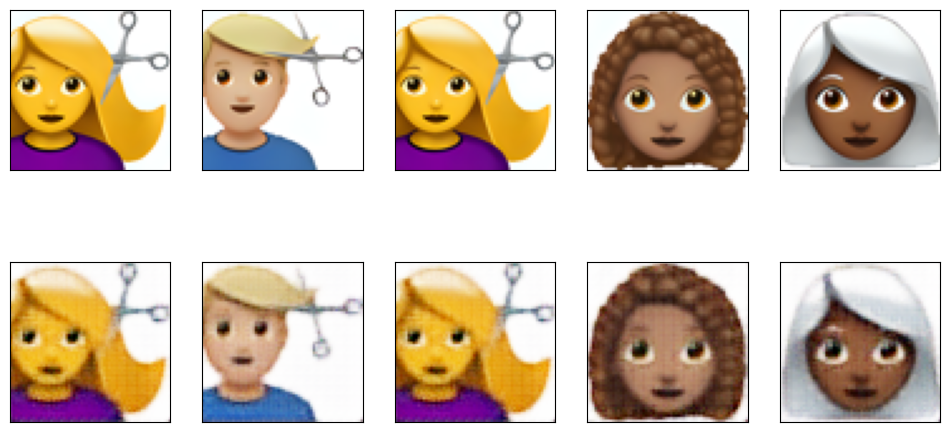

Epoch 41/100 | Training loss: 0.1641
Epoch 41/100 | Validation loss: 0.1027
Epoch 42/100 | Training loss: 0.1666
Epoch 42/100 | Validation loss: 0.1085
Epoch 43/100 | Training loss: 0.1632
Epoch 43/100 | Validation loss: 0.0985
Epoch 44/100 | Training loss: 0.1579
Epoch 44/100 | Validation loss: 0.0997
Epoch 45/100 | Training loss: 0.1600
Epoch 45/100 | Validation loss: 0.0967
Epoch 46/100 | Training loss: 0.1558
Epoch 46/100 | Validation loss: 0.0958
Epoch 47/100 | Training loss: 0.1538
Epoch 47/100 | Validation loss: 0.0975
Epoch 48/100 | Training loss: 0.1526
Epoch 48/100 | Validation loss: 0.1007
Epoch 49/100 | Training loss: 0.1509
Epoch 49/100 | Validation loss: 0.0942
Epoch 50/100 | Training loss: 0.1474
Epoch 50/100 | Validation loss: 0.0926
Epoch 51/100 | Training loss: 0.1473
Epoch 51/100 | Validation loss: 0.0913
Epoch 52/100 | Training loss: 0.1421
Epoch 52/100 | Validation loss: 0.0919
Epoch 53/100 | Training loss: 0.1474
Epoch 53/100 | Validation loss: 0.1249
Epoch 54/100

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 60/100 | Training loss: 0.1333
Epoch 60/100 | Validation loss: 0.0846


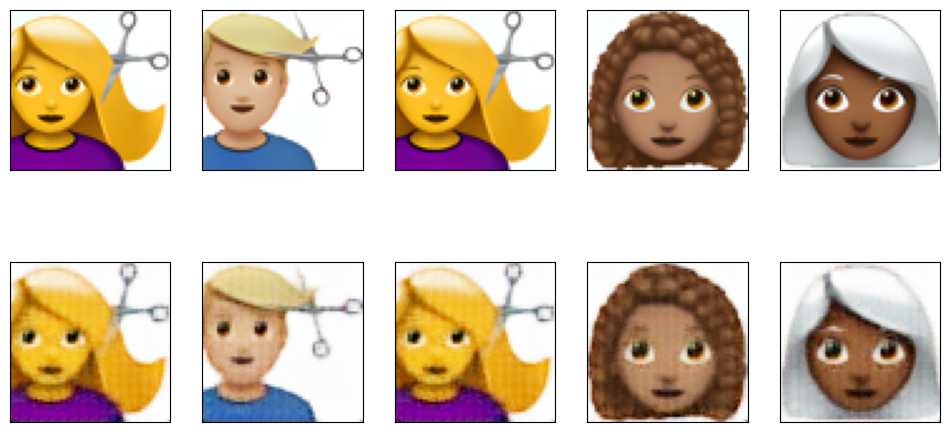

Epoch 61/100 | Training loss: 0.1326
Epoch 61/100 | Validation loss: 0.0847
Epoch 62/100 | Training loss: 0.1314
Epoch 62/100 | Validation loss: 0.0825
Epoch 63/100 | Training loss: 0.1308
Epoch 63/100 | Validation loss: 0.0803
Epoch 64/100 | Training loss: 0.1249
Epoch 64/100 | Validation loss: 0.0845
Epoch 65/100 | Training loss: 0.1285
Epoch 65/100 | Validation loss: 0.0828
Epoch 66/100 | Training loss: 0.1280
Epoch 66/100 | Validation loss: 0.0819
Epoch 67/100 | Training loss: 0.1246
Epoch 67/100 | Validation loss: 0.0770
Epoch 68/100 | Training loss: 0.1255
Epoch 68/100 | Validation loss: 0.0781
Epoch 69/100 | Training loss: 0.1224
Epoch 69/100 | Validation loss: 0.0840
Epoch 70/100 | Training loss: 0.1231
Epoch 70/100 | Validation loss: 0.0769
Epoch 71/100 | Training loss: 0.1261
Epoch 71/100 | Validation loss: 0.0812
Epoch 72/100 | Training loss: 0.1207
Epoch 72/100 | Validation loss: 0.0772
Epoch 73/100 | Training loss: 0.1192
Epoch 73/100 | Validation loss: 0.0756
Epoch 74/100

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


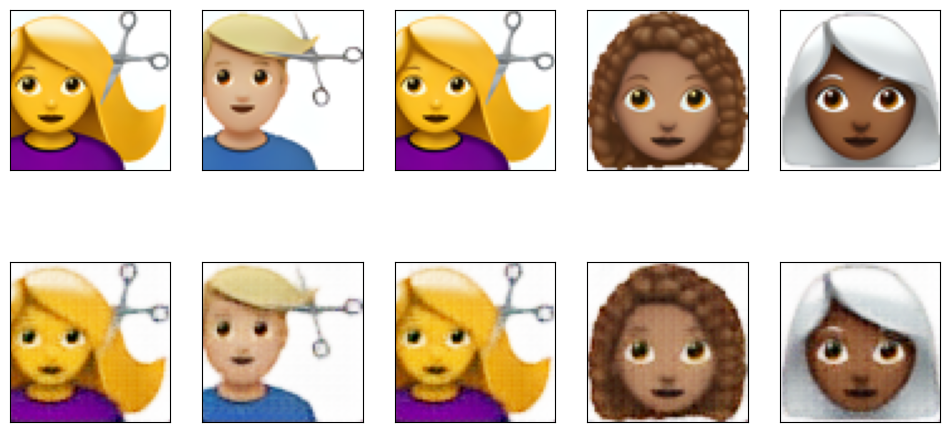

Epoch 81/100 | Training loss: 0.1135
Epoch 81/100 | Validation loss: 0.0737
Epoch 82/100 | Training loss: 0.1123
Epoch 82/100 | Validation loss: 0.0723
Epoch 83/100 | Training loss: 0.1086
Epoch 83/100 | Validation loss: 0.0721
Epoch 84/100 | Training loss: 0.1155
Epoch 84/100 | Validation loss: 0.0701
Epoch 85/100 | Training loss: 0.1082
Epoch 85/100 | Validation loss: 0.0682
Epoch 86/100 | Training loss: 0.1111
Epoch 86/100 | Validation loss: 0.0980
Epoch 87/100 | Training loss: 0.1151
Epoch 87/100 | Validation loss: 0.0759
Epoch 88/100 | Training loss: 0.1082
Epoch 88/100 | Validation loss: 0.0692
Epoch 89/100 | Training loss: 0.1032
Epoch 89/100 | Validation loss: 0.0692
Epoch 90/100 | Training loss: 0.1031
Epoch 90/100 | Validation loss: 0.0662
Epoch 91/100 | Training loss: 0.1027
Epoch 91/100 | Validation loss: 0.0668
Epoch 92/100 | Training loss: 0.1061
Epoch 92/100 | Validation loss: 0.0698
Epoch 93/100 | Training loss: 0.1022
Epoch 93/100 | Validation loss: 0.0664
Epoch 94/100

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 100/100 | Training loss: 0.1027
Epoch 100/100 | Validation loss: 0.0676


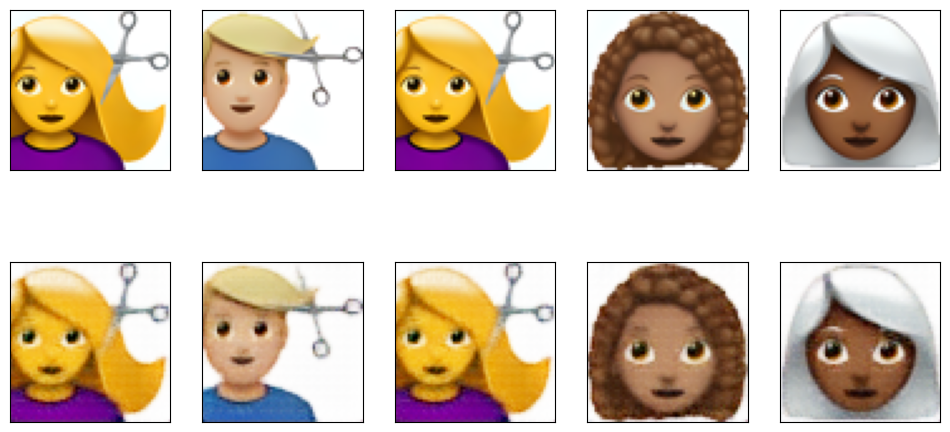

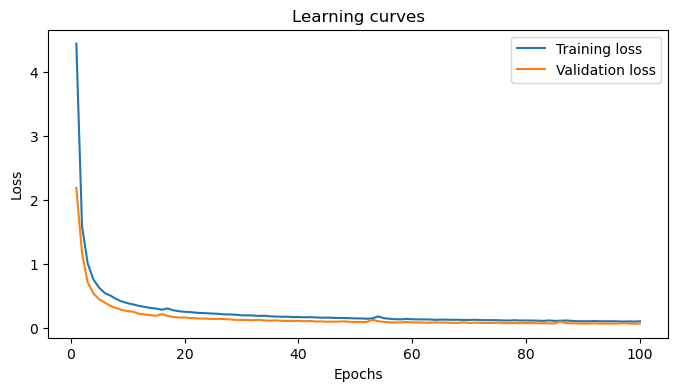

Test loss: 0.0616


In [49]:
import matplotlib.pyplot as plt

torch.manual_seed(42)

# apple silicon acceleration
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('MPS is available')
else:
    device = torch.device('cpu')

# Create the autoencoder model
model = Autoencoder()
model = model.to(device)

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
n_epochs = 100

train_losses = []
val_losses = []

for epoch in range(1, n_epochs+1):
    model.train()
    train_loss = 0.0
    for data in train_dataloader:
        images = data.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss = train_loss / len(train_dataloader)
    train_losses.append(train_loss)
    print(f"Epoch {epoch}/{n_epochs} | Training loss: {train_loss:.4f}")

    # Validate the model
    val_loss = 0.0
    model.eval()
    for data in val_dataloader:
        images = data.to(device)
        outputs = model(images)
        loss = criterion(outputs, images)
        val_loss += loss.item() * images.size(0)
    val_loss = val_loss / len(val_dataloader)
    val_losses.append(val_loss)
    print(f"Epoch {epoch}/{n_epochs} | Validation loss: {val_loss:.4f}")

    # Display the test images and the reconstructed images from the autoencoder. This will allow us to see how well we're performing. 
    if epoch == 1 or epoch % 20 == 0:
        test_images = next(iter(test_dataloader))
        test_images = test_images.to(device)
        reconstructed_images = model(test_images)
        reconstructed_images = reconstructed_images.cpu()
        test_images = test_images.cpu().numpy()
        reconstructed_images = reconstructed_images.detach().numpy()
        fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(12, 6))
        for images, row in zip([test_images, reconstructed_images], axes):
            for img, ax in zip(images, row):
                ax.imshow(np.squeeze(img).transpose(1, 2, 0))
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
        plt.show()

    # Display learning curves
    if epoch == n_epochs:
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.plot(range(1, epoch+1), train_losses, label='Training loss')
        ax.plot(range(1, epoch+1), val_losses, label='Validation loss')
        ax.set_title('Learning curves')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.legend()
        plt.show()


# Save the model
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, 'autoencoder.pth')
torch.save(model.state_dict(), model_path)

# Load the model
model = Autoencoder()
model.load_state_dict(torch.load(model_path))

# Evaluate the model
test_loss = 0.0
model.eval()
for data in test_dataloader:
    images = data
    images.to(device)
    outputs = model(images)
    loss = criterion(outputs, images)
    test_loss += loss.item() * images.size(0)

# Calculate the average test loss
test_loss = test_loss / len(test_dataloader)
print(f"Test loss: {test_loss:.4f}")


## Problem 1 Discussion
For this problem, we used the hair theme to diversify the emojis. As this is a small subsample, we apply random flips and rotations to augment the size of our dataset to ~600-200-200. We applied an autoencoder with a DenseBlock architecture in the encoding layers with transpose convolutions in the decoding layers. We used the Adam optimizer and the Mean Squared Error loss function. We see that the autoencoder is able to reconstruct the emojis with a high degree of accuracy. While most of the learning occurs in the first 10 epochs, we see that the model continues to learn and improve its reconstruction accuracy. We have not yet overfit as our validation loss is still decreasing. Our reconstructed images appear to have small dots in them, which may be a function of a more simplistic decoder architecture as opposed to the deep encoder.

# Problem 2

In [50]:
def filter_and_label_images(dataset, theme):
    filtered_images = []
    labels = []
    for i, text in enumerate(dataset['train']['text']):
        if theme in text:
            if 'woman' in text:
                labels.append(1)
                filtered_images.append(dataset['train']['image'][i])
            elif 'man' in text:
                labels.append(0)
                filtered_images.append(dataset['train']['image'][i])
            # elif 'person' in text:
            #     labels.append(2)
            #     filtered_images.append(dataset['train']['image'][i])
            # else:
            #     labels.append(3)
            #     filtered_images.append(dataset['train']['image'][i])
    return filtered_images, labels

# Filter the images and assign labels
theme = 'hair'
filtered_images, labels = filter_and_label_images(dataset, theme)

# Display the length of the filtered images and labels
print(f"Number of images with the theme '{theme}': {len(filtered_images)}")
print(f"Number of labels: {len(labels)}")


Number of images with the theme 'hair': 48
Number of labels: 48


In [51]:
def resize_images(images, size):
    resized_images = []
    for image in images:
        img = image.resize(size)
        resized_images.append(img)
    return resized_images

# Resize the images
size = (64, 64)
resized_images = resize_images(filtered_images, size)

In [52]:
# Let's split the images and corresponding labels into training, validation, and test sets using a 60-20-20 split.
train_images, val_test_images, train_labels, val_test_labels = train_test_split(resized_images, labels, test_size=0.4, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(val_test_images, val_test_labels, test_size=0.5, random_state=42)

# Display the number of images in each set
print(f"Number of training images: {len(train_images)}")
print(f"Number of validation images: {len(val_images)}")
print(f"Number of test images: {len(test_images)}")

Number of training images: 28
Number of validation images: 10
Number of test images: 10


In [53]:
# Expand the dataset by duplicating the images and labels to be 600, 200, and 200 for the training, validation, and test sets, respectively.
train_images = train_images * (600 // len(train_images))
val_images = val_images * (200 // len(val_images))
test_images = test_images * (200 // len(test_images))
train_labels = train_labels * (600 // len(train_labels))
val_labels = val_labels * (200 // len(val_labels))
test_labels = test_labels * (200 // len(test_labels))

# Display the number of images in each set
print(f"Number of training images: {len(train_images)}")
print(f"Number of validation images: {len(val_images)}")
print(f"Number of test images: {len(test_images)}")

Number of training images: 588
Number of validation images: 200
Number of test images: 200


In [54]:
# Create the EmojiDataset2 class to load the images and labels
class EmojiDataset2(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [55]:
# Create the training, validation, and test datasets
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor()
])

train_dataset2 = EmojiDataset2(train_images, train_labels, transform=transform)
val_dataset2 = EmojiDataset2(val_images, val_labels, transform=transforms.ToTensor())
test_dataset2 = EmojiDataset2(test_images, test_labels, transform=transforms.ToTensor())

# Create the training, validation, and test dataloaders
train_dataloader2 = DataLoader(train_dataset2, batch_size=32, shuffle=True)
val_dataloader2 = DataLoader(val_dataset2, batch_size=32, shuffle=False)
test_dataloader2 = DataLoader(test_dataset2, batch_size=32, shuffle=False)

In [89]:
import torch.nn.functional as F

class AutoencoderWithClassifier(nn.Module):
    def __init__(self):
        super(AutoencoderWithClassifier, self).__init__()
        # Encoder
        self.encoder =  nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),   # b, 16, 32, 32
            nn.LeakyReLU(True),
            DenseConvBlock(32, 64),  # b, 64, 32, 32
            nn.MaxPool2d(2, stride=2),  # b, 64, 16, 16
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # b, 64, 32, 32
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # b, 3, 64, 64
            nn.Tanh()
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(64 * 16 * 16, 64),
            nn.LeakyReLU(True),
            nn.Dropout(0.2),
            nn.Linear(64, 2)
        )

    def forward(self, initial_x):
        # Autoencoder
        # Encoding
        enc_x = self.encoder(initial_x)
        if self.training:
            noise = torch.randn_like(enc_x)
            enc_x = enc_x + 0.05*noise
        x = self.decoder(enc_x)
        
        # Classifier
        aux = self.classifier(enc_x)
        return x, aux

MPS is available


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1/100 | Training loss: 4.0647 | MSE loss: 4.0605 | Classifier loss: 42.0933
Epoch 1/100 | Validation loss: 1.4622 | MSE loss: 1.4622 | Classifier loss: 0.5514


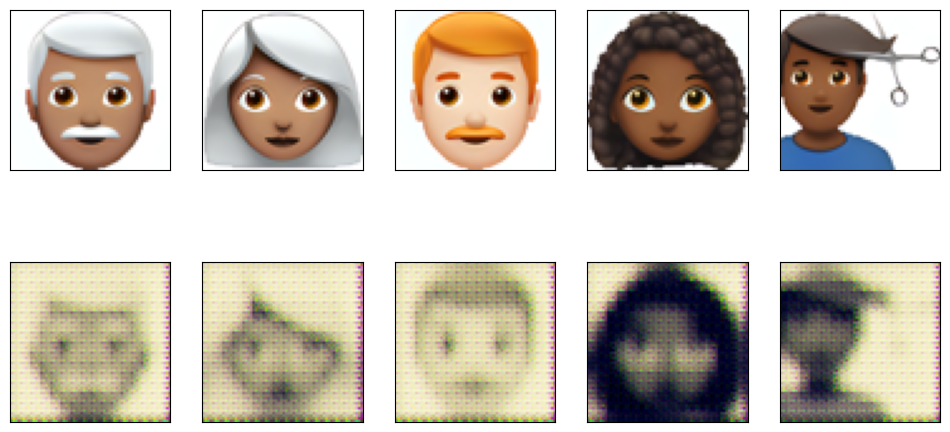

Model saved at models/autoencoderwithclassifier.pth
Epoch 2/100 | Training loss: 1.4315 | MSE loss: 1.4312 | Classifier loss: 2.4635
Epoch 2/100 | Validation loss: 0.7359 | MSE loss: 0.7358 | Classifier loss: 0.4145
Model saved at models/autoencoderwithclassifier.pth
Epoch 3/100 | Training loss: 0.8842 | MSE loss: 0.8841 | Classifier loss: 0.7767
Epoch 3/100 | Validation loss: 0.5082 | MSE loss: 0.5082 | Classifier loss: 0.2503
Model saved at models/autoencoderwithclassifier.pth
Epoch 4/100 | Training loss: 0.6838 | MSE loss: 0.6838 | Classifier loss: 0.3339
Epoch 4/100 | Validation loss: 0.4351 | MSE loss: 0.4351 | Classifier loss: 0.4473
Model saved at models/autoencoderwithclassifier.pth
Epoch 5/100 | Training loss: 0.5821 | MSE loss: 0.5821 | Classifier loss: 0.0595
Epoch 5/100 | Validation loss: 0.3289 | MSE loss: 0.3289 | Classifier loss: 0.0047
Model saved at models/autoencoderwithclassifier.pth
Epoch 6/100 | Training loss: 0.4996 | MSE loss: 0.4996 | Classifier loss: 0.0581
Epo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 20/100 | Training loss: 0.2347 | MSE loss: 0.2347 | Classifier loss: 0.0001
Epoch 20/100 | Validation loss: 0.1163 | MSE loss: 0.1163 | Classifier loss: 0.0000


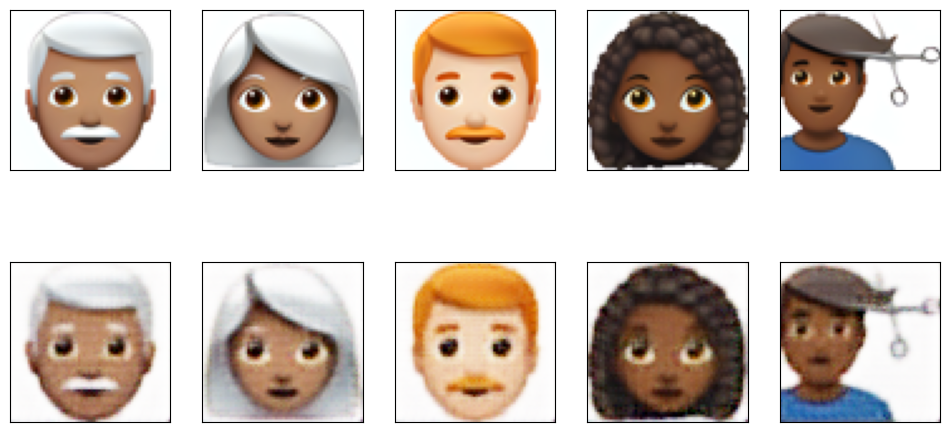

Model saved at models/autoencoderwithclassifier.pth
Epoch 21/100 | Training loss: 0.2265 | MSE loss: 0.2265 | Classifier loss: 0.0000
Epoch 21/100 | Validation loss: 0.1146 | MSE loss: 0.1146 | Classifier loss: 0.0000
Model saved at models/autoencoderwithclassifier.pth
Epoch 22/100 | Training loss: 0.2198 | MSE loss: 0.2198 | Classifier loss: 0.0000
Epoch 22/100 | Validation loss: 0.1184 | MSE loss: 0.1184 | Classifier loss: 0.0000
Epoch 23/100 | Training loss: 0.2187 | MSE loss: 0.2187 | Classifier loss: 0.0000
Epoch 23/100 | Validation loss: 0.1081 | MSE loss: 0.1081 | Classifier loss: 0.0000
Model saved at models/autoencoderwithclassifier.pth
Epoch 24/100 | Training loss: 0.2093 | MSE loss: 0.2093 | Classifier loss: 0.0000
Epoch 24/100 | Validation loss: 0.1075 | MSE loss: 0.1075 | Classifier loss: 0.0000
Model saved at models/autoencoderwithclassifier.pth
Epoch 25/100 | Training loss: 0.2042 | MSE loss: 0.2042 | Classifier loss: 0.3715
Epoch 25/100 | Validation loss: 0.1008 | MSE l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


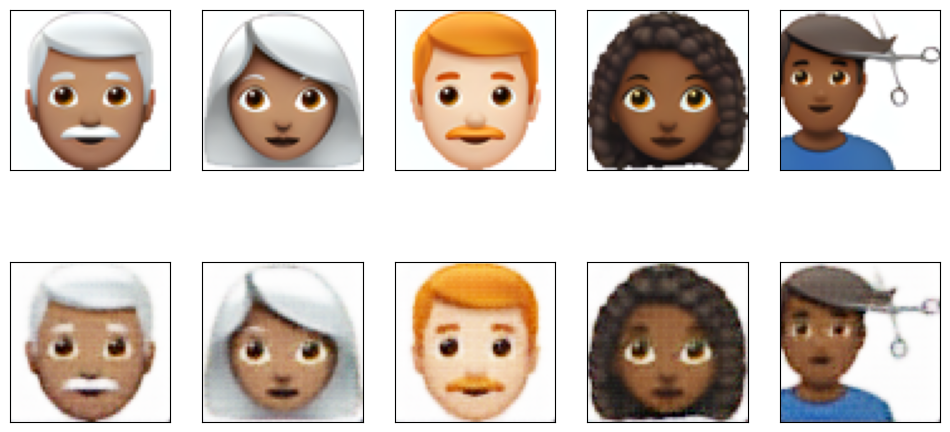

Model saved at models/autoencoderwithclassifier.pth
Epoch 41/100 | Training loss: 0.1556 | MSE loss: 0.1556 | Classifier loss: 0.0000
Epoch 41/100 | Validation loss: 0.0759 | MSE loss: 0.0759 | Classifier loss: 0.0000
Model saved at models/autoencoderwithclassifier.pth
Epoch 42/100 | Training loss: 0.1532 | MSE loss: 0.1532 | Classifier loss: 0.0000
Epoch 42/100 | Validation loss: 0.0743 | MSE loss: 0.0743 | Classifier loss: 0.0000
Model saved at models/autoencoderwithclassifier.pth
Epoch 43/100 | Training loss: 0.1519 | MSE loss: 0.1519 | Classifier loss: 0.0000
Epoch 43/100 | Validation loss: 0.0746 | MSE loss: 0.0746 | Classifier loss: 0.0000
Epoch 44/100 | Training loss: 0.1503 | MSE loss: 0.1503 | Classifier loss: 0.0000
Epoch 44/100 | Validation loss: 0.0748 | MSE loss: 0.0748 | Classifier loss: 0.0000
Epoch 45/100 | Training loss: 0.1466 | MSE loss: 0.1466 | Classifier loss: 0.0000
Epoch 45/100 | Validation loss: 0.0732 | MSE loss: 0.0732 | Classifier loss: 0.0000
Model saved at

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 60/100 | Training loss: 0.1244 | MSE loss: 0.1244 | Classifier loss: 0.0000
Epoch 60/100 | Validation loss: 0.0640 | MSE loss: 0.0640 | Classifier loss: 0.0000


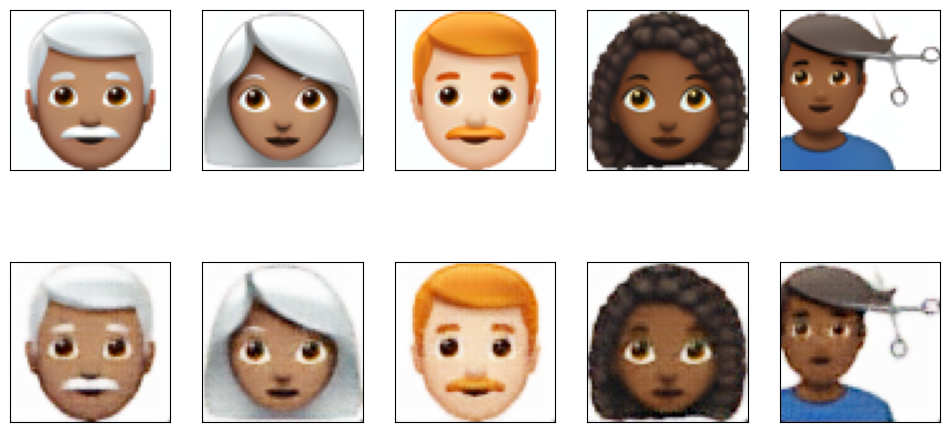

Model saved at models/autoencoderwithclassifier.pth
Epoch 61/100 | Training loss: 0.1274 | MSE loss: 0.1274 | Classifier loss: 0.0000
Epoch 61/100 | Validation loss: 0.0662 | MSE loss: 0.0662 | Classifier loss: 0.0000
Epoch 62/100 | Training loss: 0.1204 | MSE loss: 0.1204 | Classifier loss: 0.0000
Epoch 62/100 | Validation loss: 0.0645 | MSE loss: 0.0645 | Classifier loss: 0.0000
Epoch 63/100 | Training loss: 0.1230 | MSE loss: 0.1230 | Classifier loss: 0.0000
Epoch 63/100 | Validation loss: 0.0703 | MSE loss: 0.0703 | Classifier loss: 0.0000
Epoch 64/100 | Training loss: 0.1219 | MSE loss: 0.1219 | Classifier loss: 0.0000
Epoch 64/100 | Validation loss: 0.0676 | MSE loss: 0.0676 | Classifier loss: 0.0000
Epoch 65/100 | Training loss: 0.1218 | MSE loss: 0.1218 | Classifier loss: 0.0000
Epoch 65/100 | Validation loss: 0.0619 | MSE loss: 0.0619 | Classifier loss: 0.0000
Model saved at models/autoencoderwithclassifier.pth
Epoch 66/100 | Training loss: 0.1165 | MSE loss: 0.1165 | Classifi

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 80/100 | Training loss: 0.1039 | MSE loss: 0.1039 | Classifier loss: 0.0000
Epoch 80/100 | Validation loss: 0.0602 | MSE loss: 0.0602 | Classifier loss: 0.0000


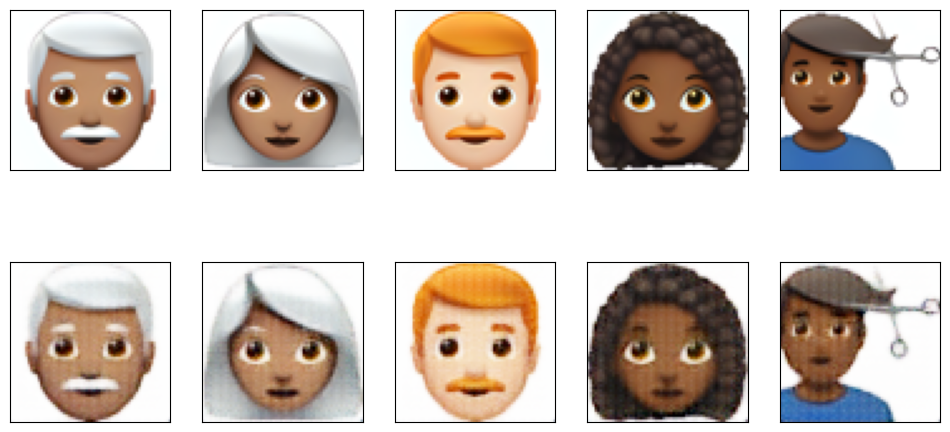

Epoch 81/100 | Training loss: 0.1088 | MSE loss: 0.1088 | Classifier loss: 0.0000
Epoch 81/100 | Validation loss: 0.0570 | MSE loss: 0.0570 | Classifier loss: 0.0000
Epoch 82/100 | Training loss: 0.1029 | MSE loss: 0.1029 | Classifier loss: 0.0000
Epoch 82/100 | Validation loss: 0.0543 | MSE loss: 0.0543 | Classifier loss: 0.0000
Model saved at models/autoencoderwithclassifier.pth
Epoch 83/100 | Training loss: 0.1164 | MSE loss: 0.1164 | Classifier loss: 0.0000
Epoch 83/100 | Validation loss: 0.0569 | MSE loss: 0.0569 | Classifier loss: 0.0000
Epoch 84/100 | Training loss: 0.1065 | MSE loss: 0.1065 | Classifier loss: 0.0000
Epoch 84/100 | Validation loss: 0.0548 | MSE loss: 0.0548 | Classifier loss: 0.0000
Epoch 85/100 | Training loss: 0.1020 | MSE loss: 0.1020 | Classifier loss: 0.0000
Epoch 85/100 | Validation loss: 0.0544 | MSE loss: 0.0544 | Classifier loss: 0.0000
Epoch 86/100 | Training loss: 0.1034 | MSE loss: 0.1034 | Classifier loss: 0.0000
Epoch 86/100 | Validation loss: 0.05

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 100/100 | Training loss: 0.0937 | MSE loss: 0.0937 | Classifier loss: 0.0000
Epoch 100/100 | Validation loss: 0.0586 | MSE loss: 0.0586 | Classifier loss: 0.0000


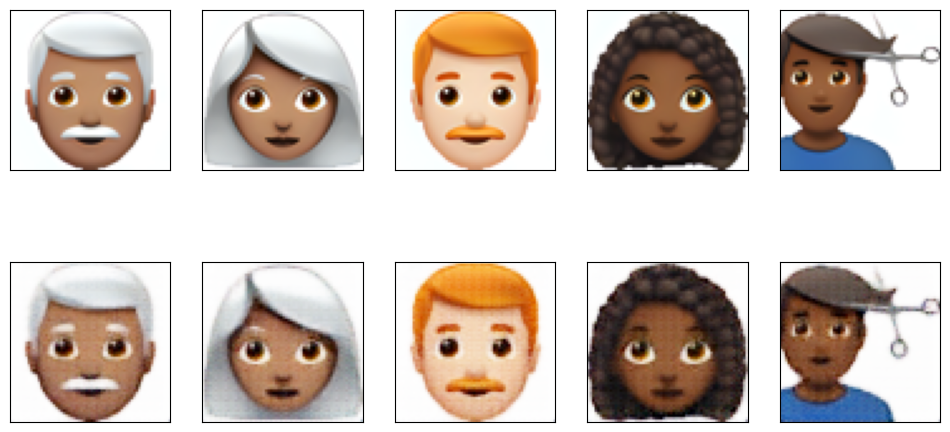

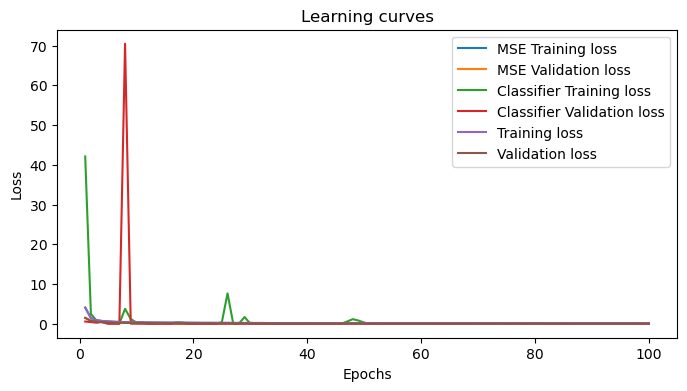

Test loss: 0.0442


In [90]:
import matplotlib.pyplot as plt
# Train the model
torch.manual_seed(42)

# apple silicon acceleration
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('MPS is available')
else:
    device = torch.device('cpu')

# Create the autoencoder model
model = AutoencoderWithClassifier()
model = model.to(device)


# Define the loss function and the optimizer
criterion = nn.MSELoss()
classifier_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.001)

# Train the model
n_epochs = 100

train_losses = []
mse_losses = []
classifier_losses = []
val_mse_losses = []
val_classifier_losses = []
val_losses = []

# Train the model with the auxiliary classifier included in the loss function
# L = L_autoencoder + lambda*L_classifier
# lambda is the auxiliary_loss_weight
auxiliary_loss_weight = .0001
best_val_loss = 1e10

for epoch in range(1, n_epochs+1):
    mse_loss = 0.0
    classifier_loss = 0.0
    train_loss = 0.0
    model.train()
    for data in train_dataloader2:
        images, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs, aux_outputs = model(images)
        mse = criterion(outputs, images)
        classifier = classifier_criterion(aux_outputs, labels)
        loss = mse + auxiliary_loss_weight * classifier
        loss.backward()
        optimizer.step()
        mse_loss += mse.item() * images.size(0)
        classifier_loss += classifier.item() * images.size(0)
        train_loss += loss.item() * images.size(0)
    mse_loss = mse_loss / len(train_dataloader2)
    classifier_loss = classifier_loss / len(train_dataloader2)
    train_loss = train_loss / len(train_dataloader2)
    mse_losses.append(mse_loss)
    classifier_losses.append(classifier_loss)
    train_losses.append(train_loss)
    print(f"Epoch {epoch}/{n_epochs} | Training loss: {train_loss:.4f} | MSE loss: {mse_loss:.4f} | Classifier loss: {classifier_loss:.4f}")

    # Validate the model
    val_mse = 0.0
    val_classifier = 0.0
    val_loss = 0.0
    model.eval()
    # with torch.no_grad():
    for data in val_dataloader2:
        images, labels = data[0].to(device), data[1].to(device)
        outputs, aux_outputs = model(images)
        val_mse_loss = criterion(outputs, images)
        val_classifier_loss = classifier_criterion(aux_outputs, labels)
        loss = val_mse_loss + auxiliary_loss_weight * val_classifier_loss
        val_mse += val_mse_loss.item() * images.size(0)
        val_classifier += val_classifier_loss.item() * images.size(0)
        val_loss += loss.item() * images.size(0)
    val_mse = val_mse / len(val_dataloader2)
    val_classifier = val_classifier / len(val_dataloader2)
    val_loss = val_loss / len(val_dataloader2)
    val_mse_losses.append(val_mse)
    val_classifier_losses.append(val_classifier)
    val_losses.append(val_loss)
    print(f"Epoch {epoch}/{n_epochs} | Validation loss: {val_loss:.4f} | MSE loss: {val_mse:.4f} | Classifier loss: {val_classifier:.4f}")

    # Display the test images and the reconstructed images from the autoencoder. This will allow us to see how well we're performing. 
    if epoch == 1 or epoch % 20 == 0:
        test_images, _ = next(iter(test_dataloader2))
        reconstructed_images, _ = model(test_images.to(device))
        test_images = test_images.numpy()
        reconstructed_images = reconstructed_images.cpu().detach().numpy()
        fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(12, 6))
        for images, row in zip([test_images, reconstructed_images], axes):
            for img, ax in zip(images, row):
                ax.imshow(np.squeeze(img).transpose(1, 2, 0))
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
        plt.show()

    # Display learning curves
    if epoch == n_epochs:
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.plot(range(1, epoch+1), mse_losses, label='MSE Training loss')
        ax.plot(range(1, epoch+1), val_mse_losses, label='MSE Validation loss')
        ax.plot(range(1, epoch+1), classifier_losses, label='Classifier Training loss')
        ax.plot(range(1, epoch+1), val_classifier_losses, label='Classifier Validation loss')
        ax.plot(range(1, epoch+1), train_losses, label='Training loss')
        ax.plot(range(1, epoch+1), val_losses, label='Validation loss')
        ax.set_title('Learning curves')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.legend()
        plt.show()
    
    # Save the model if the validation loss has decreased
    if val_mse < best_val_loss:
        best_val_loss = val_mse
        model_dir = 'models'
        os.makedirs(model_dir, exist_ok=True)
        model_path = os.path.join(model_dir, 'autoencoderwithclassifier.pth')
        torch.save(model.state_dict(), model_path)
        print(f"Model saved at {model_path}")


# Load the model
model = AutoencoderWithClassifier()
model.load_state_dict(torch.load(model_path))
model.to(device)

# Evaluate the model
test_loss = 0.0
model.eval()
for data in test_dataloader2:
    images, labels = data[0].to(device), data[1].to(device)
    outputs, _ = model(images)
    loss = criterion(outputs, images)
    test_loss += loss.item() * images.size(0)

# Calculate the average test loss
test_loss = test_loss / len(test_dataloader2)
print(f"Test loss: {test_loss:.4f}")

## Problem 2 Discussion
We see that adding the auxiliary task improves our autoencoder's performance, .0442 with the auxiliary task vs. .0616 without on the same Autoencoder structure and hyperparameters. We can squeeze just a little bit more out of this model by having it create a latent encoding that more closely resembles the important features of the original image (ie such that it can be properly classified as man or woman). However, because the classification task is significantly easier than the autoencoding task, this was actually very difficult to tune (Hence we set some ridiculous Dropouts to keep the classifier from converging too early). Improperly setting the lambda hyperparameter can lead to the model overemphasizing features important to the classification task such that there is underflow to the autoencoding task and it performs worse. Having a more robust dataset and classification task would help with this as it would force the model to create a broad latent encoding that is more representative of the original image while emphasizing important features for classification.

# Problem 3

In [79]:
# Get glasses images

theme = 'nerd'
nerd = filter_images(dataset, theme)

bald= filter_images(dataset, 'man bald')

# Resize the images
size = (64, 64)
nerd = resize_images(nerd, size)
bald = resize_images(bald, size)
nerd = nerd[0]
bald = bald[0]

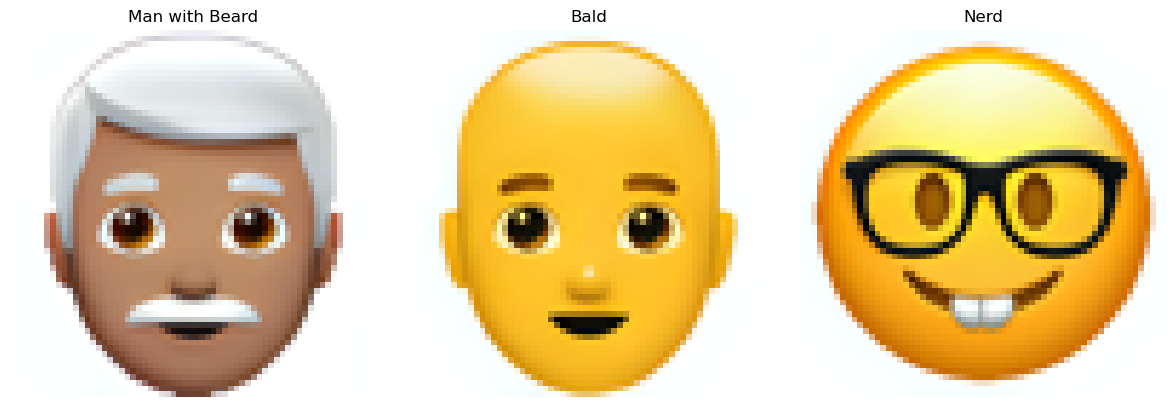

In [80]:
# get the first test image
test_images, _ = next(iter(test_dataloader2))
man_with_beard = test_images[0].unsqueeze(0)

test_images = test_images.numpy()

man_with_beard_test = test_images[0]

# Display the images
# Create a subplot with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot the first test image
axes[0].imshow(np.squeeze(man_with_beard_test).transpose(1, 2, 0))
axes[0].set_title('Man with Beard')

# Plot the bald image
axes[1].imshow(bald)
axes[1].set_title('Bald')

# Plot the nerd image
axes[2].imshow(nerd)
axes[2].set_title('Nerd')

# Remove the axis labels
for ax in axes:
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [81]:
# transform the non tensor images to a tensor
transform = transforms.ToTensor()
nerd_tensor = transform(nerd).unsqueeze(0)
bald_tensor = transform(bald).unsqueeze(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


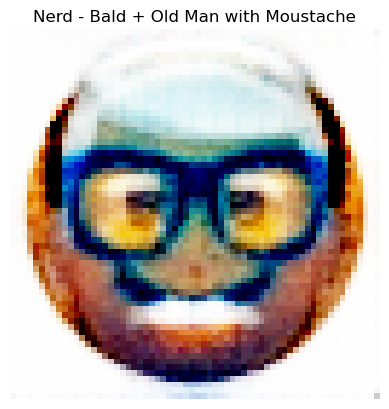

In [88]:
img_vecs = [nerd_tensor, bald_tensor, man_with_beard]

# Set the model to evaluation mode
model.eval()

# Encode the images
encoded_img_vecs = []
for img_vec in img_vecs:
    x = img_vec.to(device)
    x = model.encoder(x)
    encoded_img_vecs.append(x)


# We want to subtract the bald man from the nerd so we can add glasses to the man with beard

x = torch.subtract(encoded_img_vecs[0], encoded_img_vecs[1])
combined_encoding = torch.add(x, encoded_img_vecs[2])

combined_image = model.decoder(combined_encoding).cpu()

# Plot the combined image
plt.imshow(np.squeeze(combined_image.detach().numpy()).transpose(1, 2, 0))
plt.title('Nerd - Bald + Old Man with Moustache')
plt.axis('off')
plt.show()


## Problem 3 Discussion
While this is not a perfect representation, you can see that our vector math works! We can take the latent encodings of multiple images and perform vector operations to create a new image. In our case we subtracted a bald emoji from the nerd emoji to try and isolate the eye glasses to add it to an old man with a mustache. You can see that the glasses are clearly added with the old man's hair and mustache still represented. This image could be improved by using emoji's that are more closely related to each other. For example, the nerd and bald man emoji's are not very similar so there is noise introduced from their differences. Additionally, eyes present in the nerd and emoji are very different from the training set so that could be a reason for the noise as well.